In [24]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [25]:
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn
# !pip install numpy

In [26]:
OP_FIL_DIR = "output"

In [27]:
def load_data(file_name):
    with open(f'{OP_FIL_DIR}/{file_name}.pkl', 'rb') as f:
        loaded_data = pickle.load(f)
    return loaded_data

def transform_df(seq_df):
    seq_df['total_time'] = seq_df['total_time'].astype(int)
    seq_df['avg_step_time'] = seq_df['avg_step_time'].astype(int)
    seq_df['build_tree_time'] = seq_df['build_tree_time'].astype(int)
    seq_df['compute_forces_time'] = seq_df['compute_forces_time'].astype(int)
    seq_df['steps'] = seq_df['steps'].astype(int)
    seq_df['n_processors'] = seq_df['n_processors'].astype(int)
    return seq_df

def load_df(file_name):
    data = load_data(file_name)
    df = pd.DataFrame(data)
    df = transform_df(df)
    return df

In [28]:
seq_df = load_df("sequential_data")
mpi_df = load_df("mpi_data")

def add_speedup_column(df):
    for file in df['file'].unique():
        for steps in df['steps'].unique():
            subset = df[(df['file'] == file) & (df['steps'] == steps)]
            total_time_n1 = subset[subset['n_processors'] == 1]['total_time'].values[0]
            df.loc[(df['file'] == file) & (df['steps'] == steps), 'speed_up'] = \
                total_time_n1 / subset['total_time']
    return df

seq_df_2 = seq_df.drop(columns=['avg_step_time', 'build_tree_time', 'compute_forces_time', 'update_position_velocity_time'])
seq_df_2 = seq_df_2[seq_df_2['steps'] != 10000]
seq_df_2 = seq_df_2[seq_df_2['file'] != 'nb-10.txt']
mpi_df2 = mpi_df.drop(columns=['avg_step_time', 'build_tree_time', 'compute_forces_time', 'update_position_velocity_time'])
mpi_df2 = mpi_df2[mpi_df2['n_processors'] != 1]
mpi_df2 = mpi_df2[mpi_df2['file'] != 'nb-10.txt']
final_df = pd.concat((mpi_df2, seq_df_2))
final_df = add_speedup_column(final_df)
final_df.head()

,total_time,file,steps,n_processors,speed_up
16,3,nb-100.txt,100,2,1.333333
17,3,nb-100.txt,100,4,1.333333
18,4,nb-100.txt,100,8,1.000000
19,8,nb-100.txt,100,16,0.500000
21,22,nb-100.txt,1000,2,1.409091


In [29]:
def plot_total_time_by_file_and_steps(df):
    unique_files = df['file'].unique()
    unique_steps = df['steps'].unique()
    
    fig, axs = plt.subplots(len(unique_files), len(unique_steps), 
                             figsize=(5*len(unique_steps), 4*len(unique_files)))
    
    colors = plt.cm.get_cmap('viridis')
    
    for i, file in enumerate(unique_files):
        for j, steps in enumerate(unique_steps):
            file_steps_data = df[(df['file'] == file) & (df['steps'] == steps)]
            file_steps_data_sorted = file_steps_data.sort_values('n_processors')
            ax = axs[i, j] if len(unique_files) > 1 and len(unique_steps) > 1 else \
                 axs[i] if len(unique_steps) == 1 else \
                 axs[j]
            
            ax.plot(
                file_steps_data_sorted['n_processors'], 
                file_steps_data_sorted['speed_up'], 
                marker='o',  # Add markers
                color=colors(i / len(unique_files))
            )
            
            ax.set_title(f'{file}\nSteps = {steps}')
            ax.set_xlabel('Number of Processors')
            ax.set_ylabel('Speed up')
            
            ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

def plot_pie_for_all_combinations(df, file):
    unique_steps = df[df['file'] == file]['steps'].unique()
    unique_processors = df[df['file'] == file]['n_processors'].unique()

    n_cols = min(4, len(unique_steps))
    n_rows = np.ceil(len(unique_processors) * len(unique_steps) / n_cols).astype(int)

    plt.figure(figsize=(15, 5 * n_rows))

    plot_count = 1

    for num_proc in unique_processors:
        for steps in unique_steps:
            subset = df[(df['file'] == file) & 
                        (df['n_processors'] == num_proc) & 
                        (df['steps'] == steps)]
            
            if len(subset) > 0:
                times = subset[['build_tree_time', 'compute_forces_time']].iloc[0]
                total_time = (times['build_tree_time'] + times['compute_forces_time'])
                
                plt.subplot(n_rows, n_cols, plot_count)
                
                labels = ['Build Tree Time', 'Compute Forces Time']
                plt.pie(times, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
                
                plt.title(f'Time Distribution\nsteps={steps}, np={num_proc}, total_time={total_time}')
                
                plot_count += 1

    plt.suptitle(f'Time Distribution for {file}', fontsize=16)
    plt.tight_layout()
    plt.show()

### GPU Hardware Details
1. Graphics: Nvidia RTX 4090 24Gb
2. Cores: 16384
3. Clock Speed: 2235Mhz
4. Memory Bandwidth (GB/sec): 1008
5. TDP: 450W


### CPU Hardware Details
1. CPU: 12th Gen Intel® Core™ i9-12900K
2. Cores: 16 (8 performance-cores(5.10 GHz) and 8 efficient-cores(3.90 GHz))
3. Threads: 24
4. Cache: 30MB
5. L2 Cache: 14MB

### RAM: 64GB
### OS: Ubuntu 24.04.1 LTS

### Amount of time spend on lab: ~40hrs



# Lab #5: MPI Barnes-hut
## High Level Approach
* I began the assignment by researching quad trees and how to implement one by consulting multiple online sources.
* I spent additional time reviewing the assignment requirements to understand the Multipole Acceptance Criteria and Leapfrog-Verlet Integration in the MPI Barnes-Hut algorithm.

#### Design Considerations
* I aimed to reuse most of the code from the sequential implementation in the parallel one, but I found that the MPI interface allowed us to achieve this easily. Initially, I had anticipated needing more modifications as we did in the CUDA.
* **Data Structure**:  
    1. Given that we are working extensively with 2D positions, I decided to define a data structure that holds positions and handles operations in a manner similar to scalar values. This approach would help keep the implementation simpler. As a result, I created a `Vec2` (vector-2D) data structure to hold the position of any given body in 2D space.
    2. Using `Vec2`, I defined the `Body` structure to represent a particle and the `QuadTreeNode` structure to represent a node in the quadtree. All the functions related to the quadtree are also defined within this structure.
    3. The way these data structures are designed helped me reduce the amount of code and made the overall implementation more readable.


#### Building the Quad Tree
1. **Region Representation Approaches:**
    - Start the quadrant representation from `(0,0)` with a side length of 4, or
    - Start the quadrant representation from `(2,2)` with a side length of 2.
2. I opted for the first approach since both methods only differ in how the four child quadrants are calculated. I found the first approach simpler to understand and code.
3. The `QuadTreeNode` structure is defined as follows:
    - `Body body`: A pointer to hold a particle or body.
    - `Vec2 center_of_mass`: A 2D vector for the coordinates of the center of mass.
    - `Vec2 region`: A 2D vector representing the current region's coordinates.
    - `double side_length`: A value used with the region to determine the area of the represented region.
    - `double total_mass`: The total mass of the subtree.
    - `bool is_internal`: A flag to indicate whether the node is internal.
    - `QuadTreeNode *sw, *se, *ne, *nw`: Pointers to hold the children of the node.
4. When a node requires a child, the quad tree splits the node into four children, ensuring only one particle exists per region.
5. A visualization of the quad tree from the code is shown in the image below.

#### Center of Mass Calculation
1. The center of mass for each node in the tree is calculated during the tree construction process.
2. I decided that an additional recursion to specifically compute the center of mass was unnecessary.

#### Force Calculation and Position, Velocity Update
1. After building the tree for each time-step, the force for each body is computed to update its position and velocity.
2. The force is recursively calculated—if a particle is far enough from the region, determined by the region length, distance, and theta, the force is computed using the center of mass of the region.
3. Once the forces for all bodies have been calculated, the velocity and position of each body are updated.


#### MPI
1. Reading and Broadcasting Particles:
    * The first process (rank 0) reads the particle data from the input file and broadcasts the number of particles (n_particles) to all other processes using MPI_Bcast.
    * All other processes then allocate a buffer to hold the n_particles based on the broadcasted number.
    * The first process also broadcasts the actual particle data to all other processes using MPI_Bcast.
2. Local Tree Construction:
    * Once the particles have been distributed, each process constructs its own quadtree using the particles assigned to it. This is done by dividing the particles evenly among all processes.
    * Each process also computes the center of mass for each subregion of its quadtree.
3. Force Computation and Particle Updates:
    * After building the quadtree, each process performs a traversal of its local tree to compute the gravitational forces on its set of particles.
    * The force calculations are done in parallel by each process, considering the local particles and the global structure of the quadtree.
    * After computing the forces, each process updates the positions and velocities of its particles based on the computed forces and the given timestep.
4. Broadcasting Particle Updates:
    * Once a process has finished updating its particles, it broadcasts its updated set of particles using MPI_Ibcast (non-blocking broadcast) to all other processes.
    * The broadcast ensures that all processes stay synchronized with the latest state of the particles.

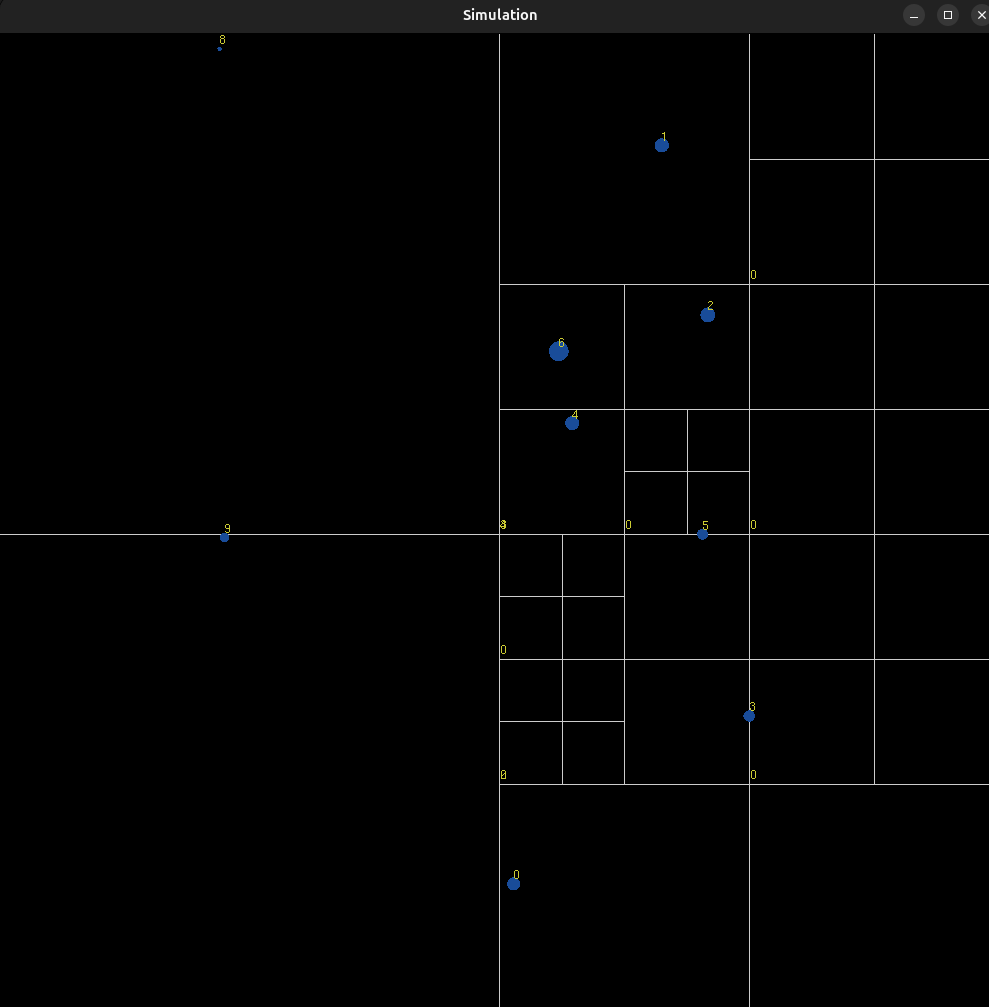

#### Time Distribution Between Building the Tree and Force Computation for 100k dataset

##### Sequential Implementation

1. **Force Computation Dominates Execution Time**  
    In the sequential implementation, the majority of the time (~90%) is spent on calculating forces. This behavior remains consistent across different numbers of steps (100, 1000, and 5000). The force computation is the most computationally expensive operation due to the recursive traversal of the quadtree and the need to calculate interactions between all bodies.

2. **Tree Building Time**  
    The time required to build the quadtree is relatively constant across trials, regardless of the number of simulation steps. Once the tree structure is constructed, the forces can be computed based on the spatial relationships within the tree.


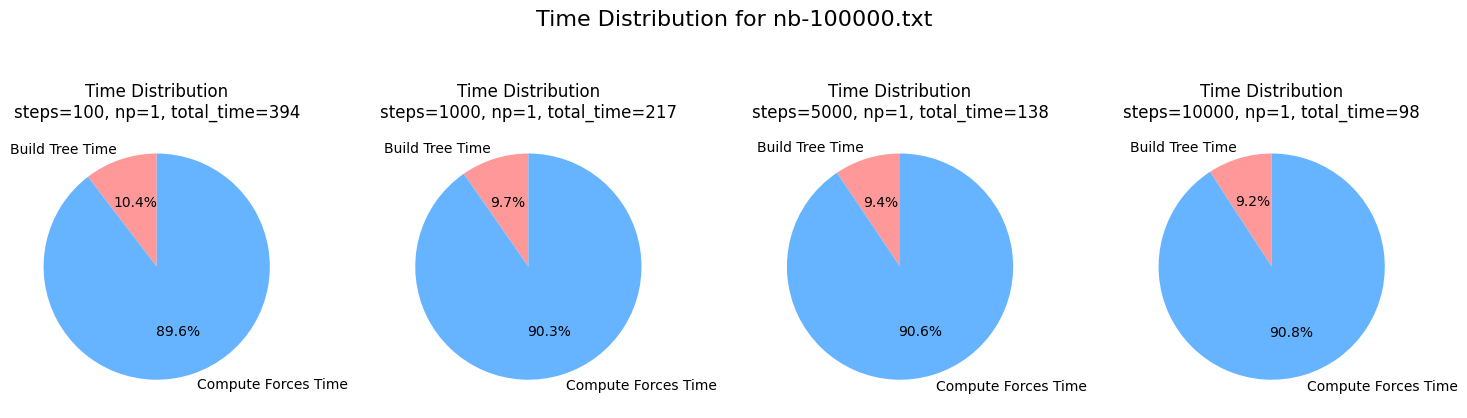

In [30]:
plot_pie_for_all_combinations(seq_df, 'nb-100000.txt')

##### MPI Implementation

1. **Time Distribution with Increasing Processors**  
    In the MPI implementation, the fraction of time spent on force computation steadily decreased as the number of processors increased. Conversely, the fraction of time spent on building the tree increased, as shown in the pie charts below. This shift in time distribution reflects the growing impact of parallelism on force computation, with more processors accelerating the computation of forces.

2. **Impact of Parallelism on Force Computation**  
    As observed in the sequential implementation, force computation takes up the majority of the runtime. In the MPI version, the time spent on building the tree remains fairly constant, while the time spent on force computation drastically decreases due to the parallel processing. The result is a significant reduction in the fraction of time devoted to force computation, as depicted in the pie charts. This highlights the effectiveness of parallelization in improving the overall efficiency of force calculations.

3. **Total Time and Scalability**  
    When considering the total time, there is a noticeable reduction in execution time as the number of processors increases, up to 8 processors. However, beyond this point, the performance starts to degrade. This suggests that while parallelism benefits the system up to a certain number of processors, additional processors may introduce overhead or inefficiencies that hinder further improvements in performance.


In [31]:
# mpi_df

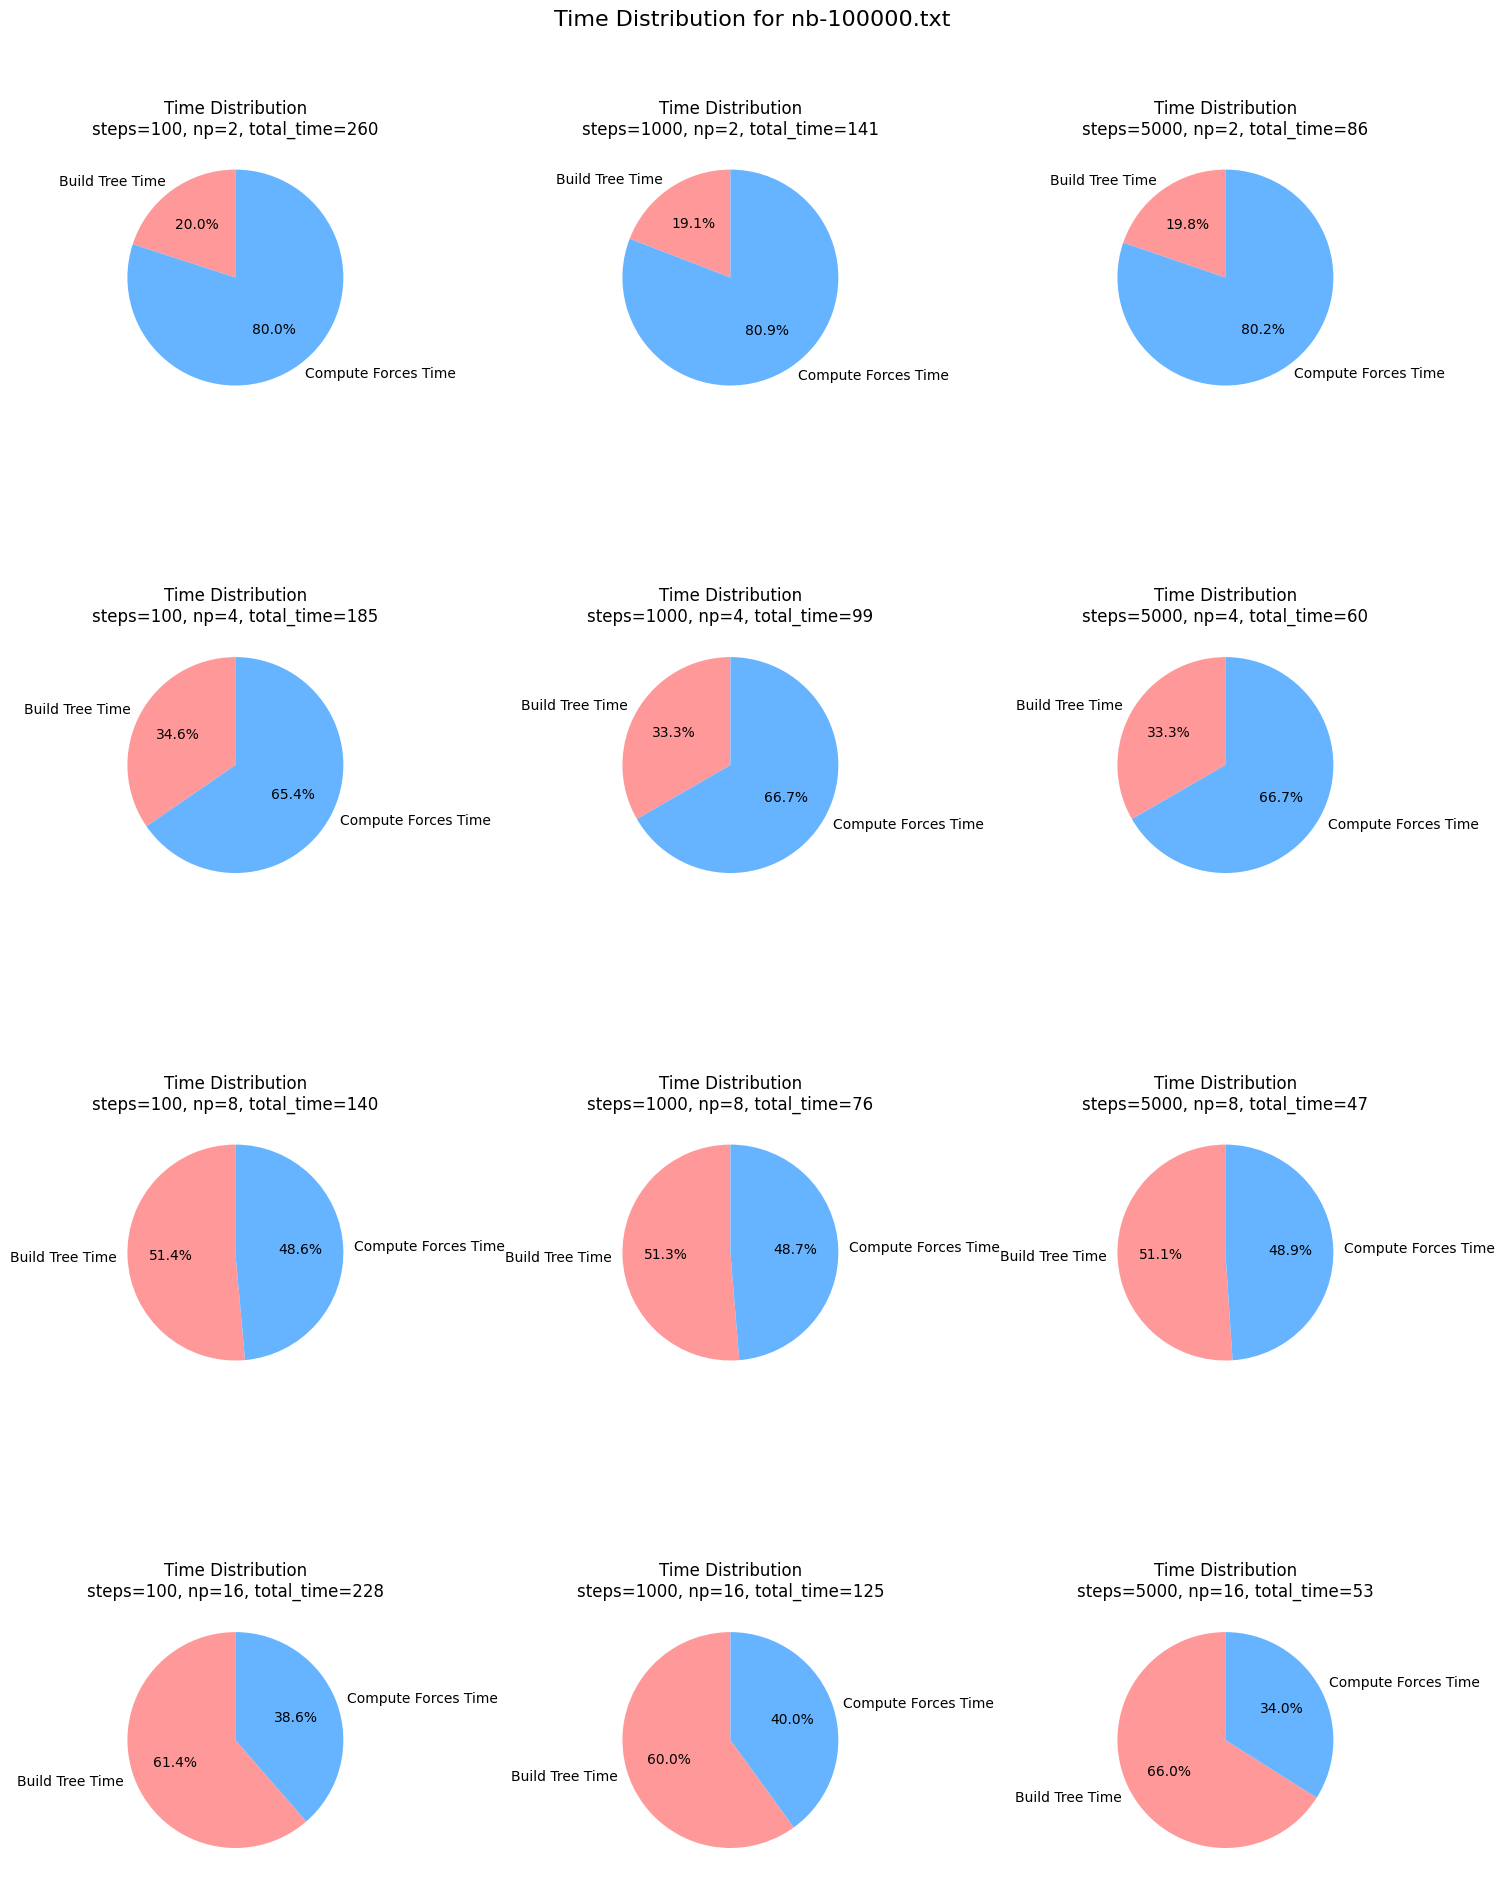

In [32]:
plot_pie_for_all_combinations(mpi_df[mpi_df['n_processors'] !=1 ], 'nb-100000.txt')

## Performance

The following graphs illustrate the speedup of the implementation for the **100** and **100k** datasets across varying numbers of time steps (100, 1000, and 5000). The key observations are outlined below:

#### 100 Dataset File
1. **Optimal Speedup at 4 Processors**  
    For the 100 dataset, the speedup across different time steps (100, 1000, 5000) is most noticeable with **4 processors**. This suggests that, with a small dataset, the parallelization overhead is relatively low at this processor count, allowing for efficient task division and reduced communication cost between processes.
  
2. **Performance Degradation with More Processors**  
    As the number of processors increases beyond 4, the performance begins to degrade. This behavior is consistent with previous observations in other assignments where smaller datasets do not scale well with an increasing number of processors. The additional overhead, such as inter-process communication and synchronization, likely outweighs the benefits of parallelism, leading to diminishing returns.

#### 100k Dataset File
1. **Notable Speedup at 8 Processors**  
    In the case of the 100k dataset, the speedup is more pronounced, with a factor of approximately **2.5** at 1000 steps when using **8 processors**. This indicates that the larger dataset benefits significantly from parallelism, especially with a higher number of processors, where the workload is more evenly distributed and the parallel computation effectively reduces the overall execution time.

2. **Consistent Speedup Across All Steps**  
    The speedup remains consistent across the different time steps (100, 1000, and 5000), with the maximum speedup observed at **8 processors**. This suggests that, for a larger dataset, the computational workload scales well with the number of processors, and the parallelization benefits are more stable across different simulation durations.

3. **Performance Trend Beyond 8 Processors**  
    The performance consistently improves until the number of processors reaches **8**, after which it starts to degrade. However, even with performance degradation beyond 8 processors, the parallel implementation still outperforms the sequential version. This could be due to factors such as communication overhead, memory contention, or limited scalability of the algorithm past a certain number of processors. The dataset size and the increasing complexity of inter-process communication as more processors are added might contribute to this behavior.

### Additional Insights:
- **Dataset Size Matters:** The key takeaway from these observations is that the dataset size plays a critical role in determining the optimal number of processors. Smaller datasets benefit less from additional processors due to increased overhead, while larger datasets can efficiently scale with more processors up to a certain threshold.
- **Scalability Limitations:** The performance degradation observed after a certain number of processors suggests that, although parallelism improves performance, there are practical limits to how much the system can scale. Factors such as network communication, load balancing, and the inherent complexity of the algorithm may limit the scalability beyond a certain point.



/tmp/ipykernel_1682599/3002245721.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis')


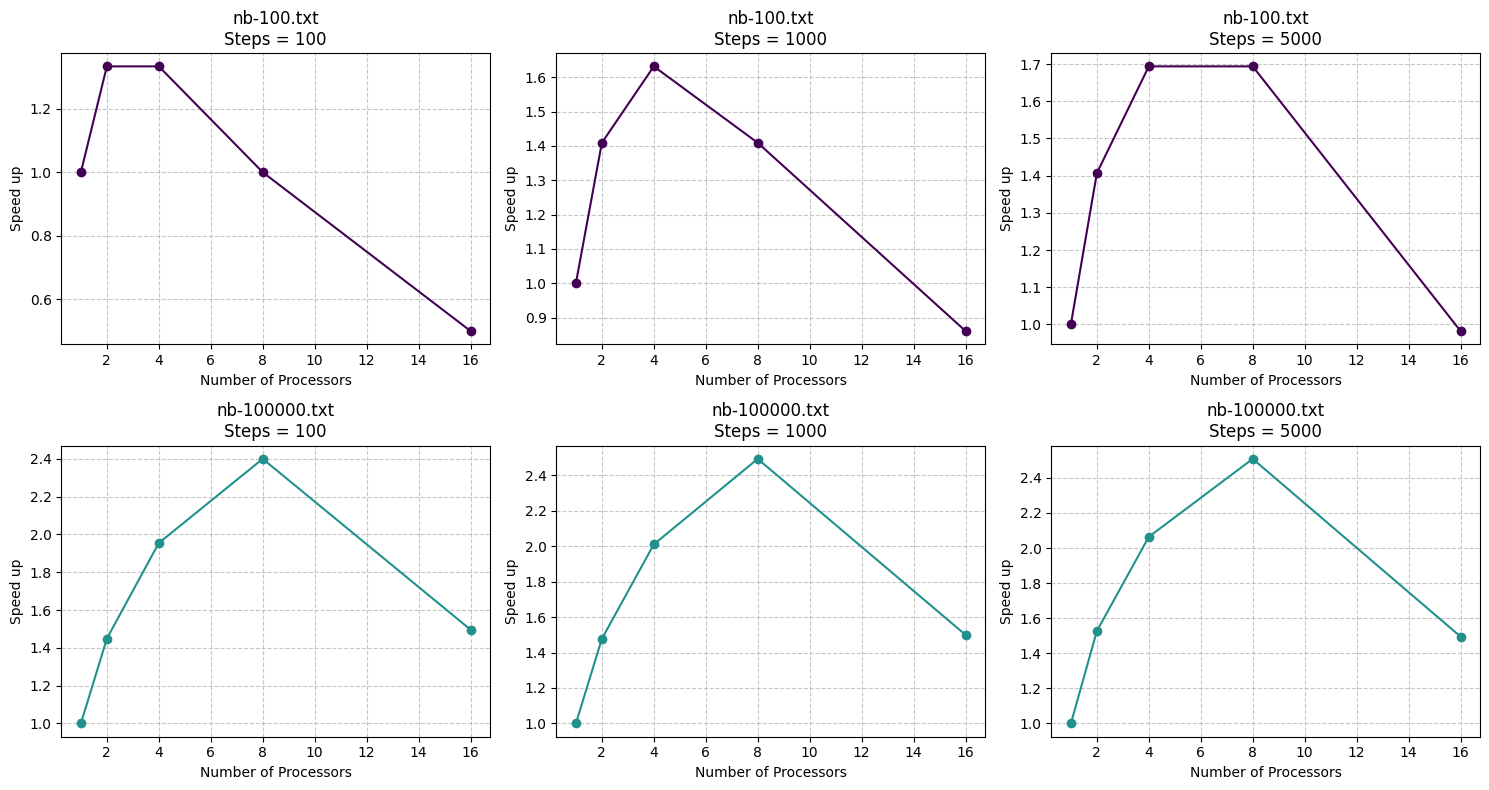

In [33]:
plot_total_time_by_file_and_steps(final_df)